In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import cv2

image_path = tf.keras.utils.get_file(
    'YellowLabradorLooking_new.jpg',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'
)
img = image.load_img(image_path, target_size=(224, 224))
img_array = image.img_to_array(img)
input_image = np.expand_dims(img_array, axis=0)
input_image = preprocess_input(input_image)

model = ResNet50(weights='imagenet')
original_preds = model.predict(input_image)
print("Original prediction:", decode_predictions(original_preds, top=3)[0])

loss_object = tf.keras.losses.CategoricalCrossentropy()
epsilon = 0.05
label_index = tf.argmax(original_preds[0])
label = tf.one_hot(label_index, 1000)
label = tf.reshape(label, (1, 1000))

@tf.function
def create_adversarial_image(image, label):
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = loss_object(label, prediction)
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    adversarial_image = image + epsilon * signed_grad
    return tf.clip_by_value(adversarial_image, -128.0, 128.0)

adv_image = create_adversarial_image(input_image, label)
adv_preds = model.predict(adv_image)
print("Adversarial prediction:", decode_predictions(adv_preds, top=3)[0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Original prediction: [('n02091244', 'Ibizan_hound', np.float32(0.1603632)), ('n02091831', 'Saluki', np.float32(0.113766335)), ('n02099712', 'Labrador_retriever', np.float32(0.09416798))]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Adversarial prediction: [('n02099712', 'Labrador_retriever', np.float32(0.11991621)), ('n02091244', 'Ibizan_hound', np.float32(0.09357471)), ('n02091831', 'Saluki', np.float32(0.0880988))]


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_177']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


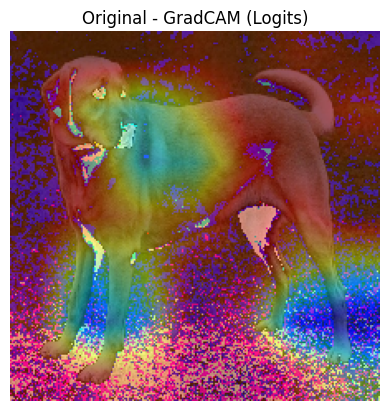

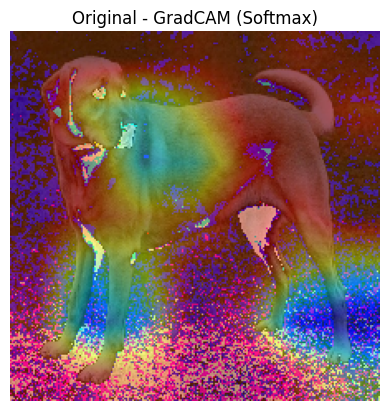

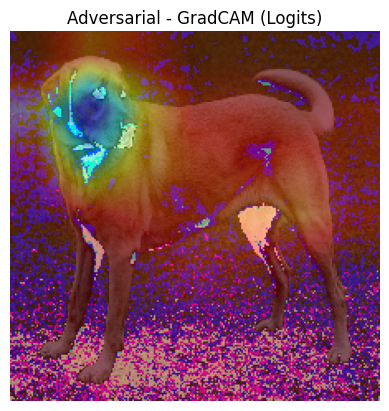

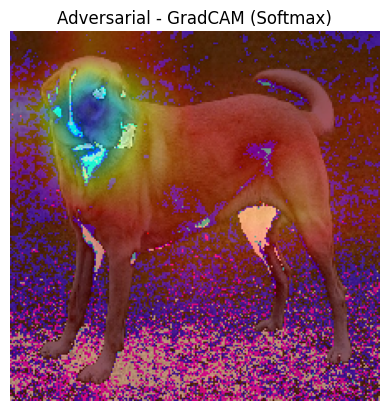

In [5]:
from tensorflow.keras.models import Model

def compute_gradcam(model, image, class_index, layer_name, use_softmax=False):
    grad_model = Model(inputs=model.inputs,
                       outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        pred = tf.nn.softmax(predictions)[0, class_index] if use_softmax else predictions[:, class_index]
    grads = tape.gradient(pred, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def display_gradcam(image_array, heatmap, title):
    img = image_array.astype(np.uint8)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(title)
    plt.show()

target_layer = "conv5_block3_out"
original_class = tf.argmax(original_preds[0]).numpy()
adv_class = tf.argmax(adv_preds[0]).numpy()

heatmap_ori_logits = compute_gradcam(model, input_image, original_class, target_layer, False)
heatmap_ori_softmax = compute_gradcam(model, input_image, original_class, target_layer, True)
heatmap_adv_logits = compute_gradcam(model, adv_image, adv_class, target_layer, False)
heatmap_adv_softmax = compute_gradcam(model, adv_image, adv_class, target_layer, True)

display_gradcam(img_array, heatmap_ori_logits, "Original - GradCAM (Logits)")
display_gradcam(img_array, heatmap_ori_softmax, "Original - GradCAM (Softmax)")
display_gradcam(img_array, heatmap_adv_logits, "Adversarial - GradCAM (Logits)")
display_gradcam(img_array, heatmap_adv_softmax, "Adversarial - GradCAM (Softmax)")


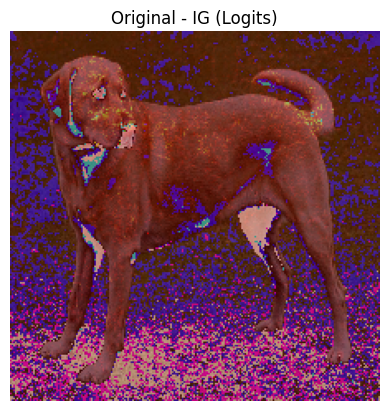

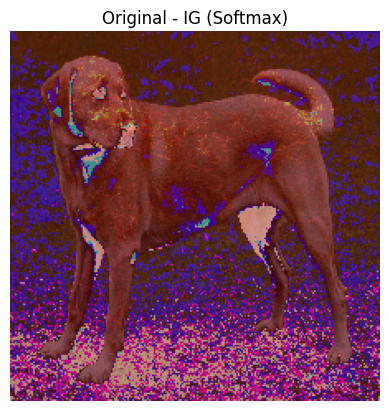

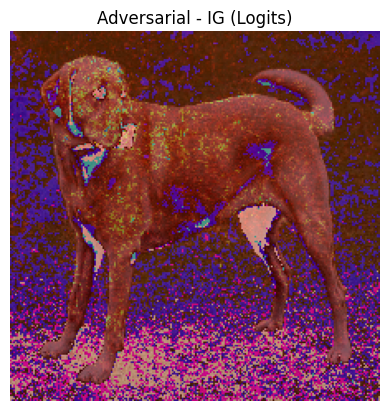

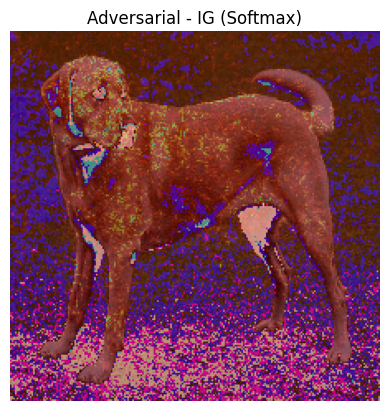

In [6]:
def integrated_gradients(model, baseline, image, class_idx, m_steps=50, use_softmax=False):
    alphas = tf.linspace(0.0, 1.0, m_steps + 1)
    delta = image - baseline
    total_gradients = 0

    for alpha in alphas:
        interpolated = baseline + alpha * delta
        with tf.GradientTape() as tape:
            tape.watch(interpolated)
            preds = model(interpolated)
            output = tf.nn.softmax(preds)[0, class_idx] if use_softmax else preds[:, class_idx]
        grads = tape.gradient(output, interpolated)
        total_gradients += grads[0]

    avg_gradients = total_gradients / (m_steps + 1)
    attributions = delta[0] * avg_gradients
    return attributions.numpy()

def display_integrated_gradients(image_array, attributions, title):
    attr_map = np.sum(np.abs(attributions), axis=-1)
    attr_map = (attr_map - np.min(attr_map)) / (np.max(attr_map) - np.min(attr_map) + 1e-8)
    attr_map = cv2.resize(attr_map, (image_array.shape[1], image_array.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * attr_map), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image_array.astype(np.uint8), 0.6, heatmap, 0.4, 0)
    plt.imshow(overlay)
    plt.axis('off')
    plt.title(title)
    plt.show()

baseline = tf.zeros_like(input_image)

ig_ori_logits = integrated_gradients(model, baseline, input_image, original_class, use_softmax=False)
ig_ori_softmax = integrated_gradients(model, baseline, input_image, original_class, use_softmax=True)
ig_adv_logits = integrated_gradients(model, baseline, adv_image, adv_class, use_softmax=False)
ig_adv_softmax = integrated_gradients(model, baseline, adv_image, adv_class, use_softmax=True)

display_integrated_gradients(img_array, ig_ori_logits, "Original - IG (Logits)")
display_integrated_gradients(img_array, ig_ori_softmax, "Original - IG (Softmax)")
display_integrated_gradients(img_array, ig_adv_logits, "Adversarial - IG (Logits)")
display_integrated_gradients(img_array, ig_adv_softmax, "Adversarial - IG (Softmax)")
